<h1>Projeto de Fundamentos de Big Data</h1>


<p>Carlos Magno Santos Ribeiro de Brito</p>
<p>Dataset: Fraudulent Transactions Data</p>


In [1]:
# libs import
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, when, count, isnan
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, NaiveBayes
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
import seaborn as sns

# set graph dark palette style
plt.style.use('dark_background')
sns.color_palette()[2]


(0.7490196078431373, 0.7333333333333333, 0.8509803921568627)

In [2]:
# Pyspark session:
MAX_MEMORY_SIZE_ALOC = '10G'
# Init pyspark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
    .set('spark.executor.heartbeatInterval', 10000) \
    .set('spark.network.timeout', 10000) \
    .set("spark.core.connection.ack.wait.timeout", "3600") \
    .set("spark.executor.memory", MAX_MEMORY_SIZE_ALOC) \
    .set("spark.driver.memory", MAX_MEMORY_SIZE_ALOC) \
    .set("spark.maxResultSize", MAX_MEMORY_SIZE_ALOC)


def init_spark():
    spark = SparkSession \
        .builder \
        .appName("big_data_fundamentals") \
        .config(conf=conf) \
        .getOrCreate()
    return spark


spark = init_spark()


22/05/15 15:35:03 WARN Utils: Your hostname, Carlos resolves to a loopback address: 127.0.1.1; using 172.23.97.230 instead (on interface eth0)
22/05/15 15:35:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/15 15:35:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# read data
data = spark.read.csv(os.path.abspath('./data/fraud.csv'),
                      header=True, inferSchema=True)
# set graph path
GRAPHS_PATH = os.path.join(os.path.abspath('./graphs/'))


os.makedirs(GRAPHS_PATH, exist_ok=True)
data.printSchema()


root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)



<h2> Dataset Information </h2>
<h3>Develop a model for predicting fraudulent transactions for a financial company and use insights from the model to develop an actionable plan.</h3>
<p><strong>step</strong>: maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).</p>
<p><strong>type</strong>: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.</p>
<p><strong>amount</strong>: amount of the transaction in local currency.</p>
<p><strong>nameOrig</strong>: customer who started the transaction.</p>
<p><strong>oldbalanceOrg</strong>: initial balance before the transaction.</p>
<p><strong>newbalanceOrig</strong>: new balance after the transaction.</p>
<p><strong>nameDest</strong>: customer who is the recipient of the transaction.</p>
<p><strong>oldbalanceDest</strong>: initial balance recipient before the transaction. Note that there is not information for customers that start with M.</p>
<p><strong>newbalanceDest</strong>: new balance recipient after the transaction. Note that there is not information for customers that start with M.</p>
<p><strong>isFraud</strong>: 1 if the transaction is fraudulent, 0 otherwise.</p>
<p><strong>isFlaggedFraud</strong>: The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.</p>


In [4]:
# view the data
data.show(5)


+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|           0.0|           0.0|      0|
+----+--------+--------+-----------+-------------+--------------+-------

In [5]:
data.describe().toPandas()


,summary,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,count,6362620,6362620,6362620,6362620,6362620,6362620,6362620,6362620,6362620,6362620
1,mean,243.39724563151657,None,179861.9035491319,None,833883.1040744886,855113.6685785907,None,1100701.6665196423,1224996.3982019203,0.001290820448180152
2,stddev,142.331971049129,None,603858.2314629348,None,2888242.673037558,2924048.502954268,None,3399180.112994467,3674128.94211965,0.035904796801604175
3,min,1,CASH_IN,0.0,C1000000639,0.0,0.0,C1000004082,0.0,0.0,0
4,max,743,TRANSFER,9.244551664E7,C999999784,5.958504037E7,4.958504037E7,M999999784,3.5601588935E8,3.5617927892E8,1


<h3>Variables exploration</h3>


In [6]:
def categoricalExplore(column):
    distinctVal = data.select(column).distinct().collect()
    emptyValues = data.where(col(column).isNull()).count()
    print(f'Col {column} -> Empty values: {emptyValues} \n Col {column} -> Distinct values: {distinctVal}')


def numericalExplore(column):
    emptyValues = data.where(isnan(column)).count()
    print(f'Col {column} -> Empty values: {emptyValues}')


# Numerical:
numericalExplore('amount')
numericalExplore('oldbalanceOrg')
numericalExplore('newbalanceOrig')
numericalExplore('oldbalanceDest')
numericalExplore('newbalanceDest')

# Categorical
categoricalExplore('type')
categoricalExplore('isFraud')


Col amount -> Empty values: 0


Col oldbalanceOrg -> Empty values: 0


Col newbalanceOrig -> Empty values: 0


Col oldbalanceDest -> Empty values: 0


Col newbalanceDest -> Empty values: 0


Col type -> Empty values: 0 
 Col type -> Distinct values: [Row(type='TRANSFER'), Row(type='CASH_IN'), Row(type='CASH_OUT'), Row(type='PAYMENT'), Row(type='DEBIT')]


Col isFraud -> Empty values: 0 
 Col isFraud -> Distinct values: [Row(isFraud=1), Row(isFraud=0)]


<p>1 - There are two categorical variables to analyze: isFraud and type;</p>
<p>2 - The 5 main numeric variables to use are: amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest and newbalanceDest;</p>


<h3>Payment type view</h3>


Text(0.5, 1.0, 'Quantity x Payment type')

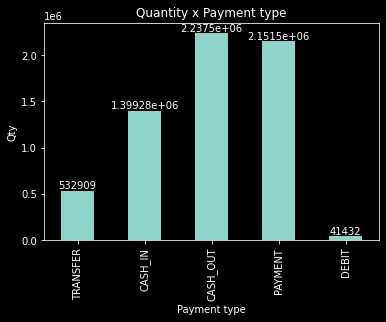

In [7]:
paymentTypeData = data.select(data.type).groupBy(data.type).count().toPandas()

ax = paymentTypeData.plot.bar(x='type', y='count', legend=False)
ax.set_ylabel('Qty')
ax.set_xlabel('Payment type')
ax.bar_label(ax.containers[0])
plt.title('Quantity x Payment type')


cash out is the most common payment type.


<h3>is Fraud view</h3>


[Text(0, 0, '8213'), Text(0, 0, '6.35441e+06')]

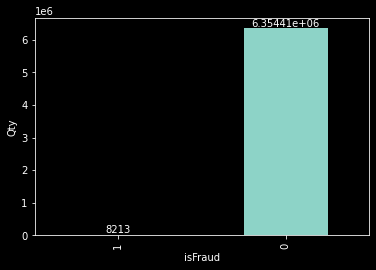

In [8]:
isFraudData = data.select(data.isFraud).groupBy(
    data.isFraud).count().toPandas()

ax = isFraudData.plot.bar(x='isFraud', y='count', legend=False)
ax.set_ylabel('Qty')
ax.bar_label(ax.containers[0])


Target Variable is highly Imbalanced.


In [9]:
isFraud = data.where(col('isFraud') == 1).count()
isNotFraud = data.where(col('isFraud') == 0).count()
print(f'Fraud detect => {isFraud}')
print(f'Fraud not detect => {isNotFraud}')


Fraud detect => 8213
Fraud not detect => 6354407


In [10]:
# Convert payment type to numeric values:
typeIndexer = StringIndexer(inputCol='type', outputCol='typeIndex')
typeEncoder = OneHotEncoder(inputCol='typeIndexer', outputCol='typeEncoder')
indexed = typeIndexer.fit(data).transform(data)

indexed.show(5)
indexed.printSchema()


+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+---------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|typeIndex|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+---------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|      1.0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|      1.0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|      3.0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|      0.0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|           0.0|           0.0|      0|   

<h2>Apply machine leaning methods and compare the results</h2>


In [11]:
assembler = VectorAssembler(inputCols=['amount', 'newbalanceOrig', 'oldbalanceOrg',
                            'oldbalanceDest', 'newbalanceDest', 'isFraud'], outputCol='features')
sc = StandardScaler(inputCol="features", outputCol="standardFeatures")


In [12]:
# Classification models:

# Naive Bayes:
nb = NaiveBayes(featuresCol='standardFeatures', labelCol='typeIndex')
pipe1 = Pipeline(stages=[assembler,
                        sc,
                        nb])
# Random Forest:
rf = RandomForestClassifier(
    featuresCol='standardFeatures', labelCol='typeIndex')
pipe2 = Pipeline(stages=[assembler,
                        sc,
                        rf])

# Decision Tree:
dt = DecisionTreeClassifier(
    featuresCol='standardFeatures', labelCol='typeIndex')
pipe3 = Pipeline(stages=[assembler,
                        sc,
                        dt])


In [13]:

# train and test split
train, test = indexed.randomSplit([0.7, 0.3], seed=2)

# evaluation metric
evaluation_metric = MulticlassClassificationEvaluator(
    predictionCol='prediction', labelCol='typeIndex')



def models(pipeline):
    model = pipeline.fit(train)
    predTarget = model.transform(indexed).select('typeIndex', 'prediction')
    acc = evaluation_metric.evaluate(
        predTarget, {evaluation_metric.metricName: "accuracy"})
    return acc


# Results:
acur = models(pipe1)
print(f'Naive Bayes accuracy {acur}')
acur = models(pipe2)
print(f'Random forest accuracy: {acur}')
acur = models(pipe3)
print(f'Decision Tree accuracy: {acur}')


Naive Bayes accuracy 0.6057303437891938


Random forest accuracy: 0.9163583555202103


Decision Tree accuracy: 0.9187171322505508



<h2>Among the three models used for classification, the decision tree model was the one with the highest accuracy.</h2>